In [1]:
import numpy as np 
import os 
import glob 
import torch 
import random 
import pickle 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps 
from skimage import measure, feature 
from scipy.spatial import distance 
from collections import defaultdict 
from sklearn.preprocessing import StandardScaler 
from tqdm.auto import tqdm 
import tifffile
from scipy.ndimage import gaussian_filter  
from wavelet import detect_spots 
import sys 
sys.path.insert(0, "../")
from model_builder import get_pretrained_model_v2 
from stats import resampling_stats 

PIXELSIZE = 0.015
CHANNEL = "FUS"


/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
latent_encoder, model_config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None, 
    mask_ratio=0.0,
    pretrained=False,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4,
)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_encoder.to(DEVICE)
latent_encoder.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [8]:
def load_files(path, exclude=None, include=None):
    files = glob.glob(path)
    files.sort()
    if exclude is not None:
        files = [f for f in files if not any([f"_{e}_" in f for e in exclude])]
    if include is not None:
        files = [f for f in files if any([f"_{i}_" in f for i in include])]
    return files

def load_svm():
    with open(f"./als-experiment/boundaries/MAE_SMALL_STED_als_svm_{CHANNEL}.pkl", "rb") as f:
        return pickle.load(f)

def extract_features(file, show=False):
    image = tifffile.imread(file)

    filtered_image = gaussian_filter(image, sigma=1.0)

    # mask = detect_spots(image, J_list=[2, 3], scale_threshold=5.0)
    mask = detect_spots(image, J_list=[3, 4], scale_threshold=2.0)

    # foreground = np.count_nonzero(mask)
    # pixels = image.shape[0] * image.shape[1]
    # ratio = foreground / pixels 
    # if ratio < 0.05:
    #     return None

    if show:    
        fig, axes = pyplot.subplots(1, 2)
        axes[0].imshow(image, cmap='gray')
        axes[1].imshow(mask, cmap='gray')
        pyplot.show()

    mask_label, num_proteins = measure.label(mask, return_num=True)
    props = measure.regionprops(mask_label, intensity_image=image)
    coordinates = np.array([p.weighted_centroid for p in props])

    distances = distance.pdist(coordinates) * PIXELSIZE
    distances = distance.squareform(distances)

    nn_distances = np.sort(distances, axis=1)[:, 1]

    image_density = num_proteins / (image.shape[0] * image.shape[1] * PIXELSIZE**2)
    density_proteins = (np.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2

    features = []
    counter = 0
    for prop, density, nn in zip(props, density_proteins, nn_distances):

        # img = prop.intensity_image
        slc = prop.slice
        img = filtered_image[slc]
        label = prop.image

        min_distance = int(0.08 / PIXELSIZE) // 2 + 1 # in pixels
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)

        if show:
            fig, axes = pyplot.subplots(1, 2)
            axes[0].imshow(img, cmap='gray')
            axes[0].plot(peaks[:, 1], peaks[:, 0], 'r.')
            axes[1].imshow(label, cmap='gray')
            pyplot.show()

        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.solidity,
            density,
            nn,
            len(peaks)
        ])

        # counter += 1
        # if counter > 5:
        #     break

    return np.array(features)

def extract_deep_features(file, show=False):
    image = tifffile.imread(file)
    
    X = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
    if torch.cuda.is_available():
        X = X.cuda()
    with torch.no_grad():
        latent = latent_encoder.forward_features(X)
        latent = latent.cpu().numpy().flatten()
    return latent
    
def gen_trajectory(files, per_protein=False, extract_deep=False):
    trajectories = defaultdict(list)
    print(f"Processing {len(files)} files")
    for file in files:
        name = os.path.basename(file).split('.')[0].split("_")[-3]
        trajectories[name].append(file)
    for name, files in tqdm(trajectories.items(), desc="Loading trajectories"):

        files = list(sorted(files, key=lambda x: int(os.path.basename(x).split('.')[0].split("_")[-1])))

        timesteps, features, deep_features = [], [], []
        counter = 0
        for file in files:
            
            if extract_deep:
                deep_feature = extract_deep_features(file)
                deep_features.append(deep_feature)

            feature_per_image = extract_features(file, show=False)
            if feature_per_image is None:
                continue
            avg_feature = np.mean(feature_per_image, axis=0)
            std_feature = np.std(feature_per_image, axis=0)

            if per_protein:
                timesteps.extend([int(os.path.basename(file).split('.')[0].split("_")[-1])] * len(feature_per_image))
                features.extend(feature_per_image)
            else:
                timesteps.append(int(os.path.basename(file).split('.')[0].split("_")[-1]))
                # features.append(
                #     np.concatenate([avg_feature, std_feature])
                # )
                features.append(
                    avg_feature
                )

        yield name, np.array(deep_features), np.array(features), np.array(timesteps)

def get_trajectory_endpoints(files, start_idx, end_idx, model):
    embeddings, labels = [], []
    for file in files:
        fname = os.path.basename(file)
        step = fname.split(".")[0].split("_")[-1]
        if step == str(start_idx):
            pred = extract_deep_features(file)
            embeddings.append(pred)
            labels.append("1")
        elif step == str(end_idx):
            pred = extract_deep_features(file)
            embeddings.append(pred)
            labels.append("0")
        else:
            continue 

    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels




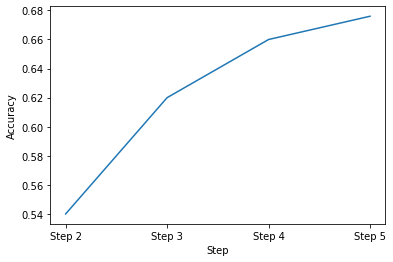

In [19]:
files = load_files(f"./als-experiment/{CHANNEL}/examples/raw-tif/*DIV14*.tif")
clf = load_svm()
accuracies = []
for end_idx in range(2, 6):
    embeddings, labels = get_trajectory_endpoints(files, 1, end_idx, model=latent_encoder)
    pred = clf.predict(embeddings)
    acc = np.sum(pred == labels) / len(labels)
    accuracies.append(acc)

x = np.arange(2, 6)
y = np.array(accuracies)

plt.plot(x, y)
plt.xticks(x, [f"Step {i}" for i in x])
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()








In [13]:
trajectory_id_per_condition, timesteps_per_condition, deep_trajectories_per_condition, trajectories_per_condition = [], [], [], []

for name, deep_features, features, steps in gen_trajectory(files, per_protein=False, extract_deep=True):
    trajectory_id_per_condition.extend([name] * len(steps))
    timesteps_per_condition.extend(steps)
    trajectories_per_condition.append(features)
    deep_trajectories_per_condition.append(deep_features)


Processing 750 files


Loading trajectories: 100%|██████████| 125/125 [00:36<00:00,  3.47it/s]


In [14]:
from tqdm import trange

class FoldChangeScaler:
    def __init__(self, trajectory_id, index=0):
        self.index = index

        self.baseline = None

    def fit_transform(self, X, trajectory_id=None):
        if trajectory_id is None:
            baselines = X[:, [self.index]]
            self.baseline = np.mean(baselines, axis=0, keepdims=True)

            return (X - baselines) / baselines

        X = X.copy()
        baselines = []
        for trajectory in set(trajectory_id):
            mask = trajectory_id == trajectory
            baseline = X[mask][[self.index], :]
            baselines.append(baseline)
        baseline = np.mean(baselines, axis=0)
        # X = np.log2(X + 1) - np.log2(baseline + 1)
        X = (X - baseline) / baseline
        # X[mask] = (X[mask] - baseline) / baseline
        return X

# Generate bootstrap trajectories
def bootstrap(samples, trajectories, n=1000):
    out = []
    for _ in trange(n):
        items = np.random.choice(samples, len(samples))
        bootstrap_sample = []
        for item in items:
            mask = trajectory_id == item
            bootstrap_sample.append(trajectories[mask])
        mean = np.mean(bootstrap_sample, axis=0)
        out.append(mean)
    out = np.array(out)
    return out

def get_confidence_interval(bootstrapped_trajectory, indices, axis=0):
    mean, cid, ciu = np.percentile(np.take(bootstrapped_trajectory, indices, axis=axis), [50, 5.0, 95], axis=0) 
    return mean, cid, ciu   

def from_categorical(names):
    unique_names = list(sorted(set(names)))
    return np.array([unique_names.index(name) for name in names])

def convert_timesteps(timesteps, invert=False):
    unique_timesteps = list(sorted(set(timesteps)))
    return np.array([
        max(unique_timesteps) - unique_timesteps.index(t) if invert else unique_timesteps.index(t) for t in timesteps])

def get_mask_real_images(timesteps):
    return np.array([t == 0 for t in timesteps])

In [15]:
scaled_trajectories = [] 
# standard_scaler = StandardScaler() 

trajectories = np.concatenate(trajectories_per_condition, axis=0)
trajectories_ = trajectories.copy()
trajectory_id = np.array(trajectory_id_per_condition)

# standard_scaler.fit(trajectories) 
scaler = FoldChangeScaler(trajectory_id, index=0)
trajectories = scaler.fit_transform(trajectories, trajectory_id=trajectory_id)
print(trajectories.shape)


bootstrapped_trajectory = bootstrap(list(set(trajectory_id)), trajectories=trajectories, n=1000)

(750, 8)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1456.80it/s]


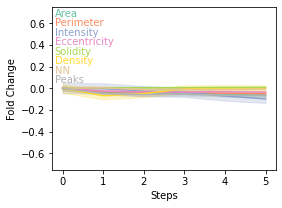

In [16]:
FEATURES = ["Area", "Perimeter", "Intensity", "Eccentricity", "Solidity", "Density", "NN", "Peaks"]
fig, ax = plt.subplots(figsize=(4, 3))
cmap = plt.get_cmap("Set2", bootstrapped_trajectory.shape[-1])
for t in range(bootstrapped_trajectory.shape[-1]):
    mean, cid, ciu = get_confidence_interval(bootstrapped_trajectory, t, axis=-1)
    ax.plot(mean, color=cmap(t))
    ax.fill_between(
        np.arange(0, bootstrapped_trajectory.shape[1], 1),
        cid, ciu, color=cmap(t), alpha=0.25
    )
    ax.annotate(
            FEATURES[t],
            xy=(0.01, 1 - 0.35 * (t + 1)/bootstrapped_trajectory.shape[1]), color=cmap(t),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
# ax.annotate(
#         condition,
#         xy=(0.99, 0.99),
#         xycoords='axes fraction',
#         horizontalalignment='right',
#         verticalalignment='top'
#     )
ax.set(
    ylim=(-0.75, 0.75), ylabel="Fold Change", xlabel="Steps"
)
plt.show()

### Deep features

##### Ensemble clustering

In [17]:
from scipy.cluster import hierarchy

2.2648870798411713
(array([1, 2, 3, 4], dtype=int32), array([  7, 683,  59,   1]))


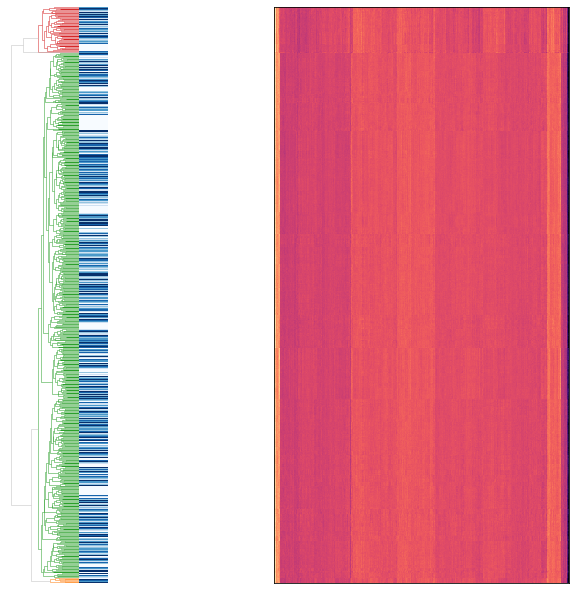

In [18]:
import matplotlib
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

SCALE = 0.8
deep_trajectories = np.concatenate(deep_trajectories_per_condition, axis=0)
# scaler = StandardScaler()
# deep_trajectories = scaler.fit_transform(deep_trajectories)
uniques = np.unique(timesteps_per_condition)
D = deep_trajectories 

distances = distance.cdist(D, D)

mask = np.triu(np.ones_like(distances, dtype=bool)) * np.invert(np.eye(len(distances), dtype=bool))
dendrogram_distance = np.quantile(distances[mask], q=0.65)
print(dendrogram_distance)
Y = hierarchy.linkage(D, method="average", metric="euclidean")
Y2 = hierarchy.linkage(D.T, method="average", metric="euclidean")

clusters = hierarchy.fcluster(Y, dendrogram_distance, "distance")
print(np.unique(clusters, return_counts=True))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0, 0, 0.1, SCALE])
ax1.set_xticks([])
ax1.set_yticks([])
fig.gca().invert_yaxis()
ax1.axis("off")

cmap = plt.get_cmap("Greys", len(np.unique(clusters)))
Z1 = hierarchy.dendrogram(
    Y, orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    ax=ax1
)
Z2 = hierarchy.dendrogram(
    Y2, orientation="left",
    color_threshold=dendrogram_distance,
    above_threshold_color="silver",
    no_plot=True
)

for collection in ax1.collections:
    collection.set_linewidth(0.5)




ax2 = fig.add_axes([0.1,0,0.04,SCALE])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')
cmap = plt.get_cmap("Blues", len(set(timesteps_per_condition)))
for i, leaf in enumerate(Z1["leaves"]):
    ax2.barh(i + 0.5, 1, 1.0, color=cmap(timesteps_per_condition[leaf]))
    # ax2.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
ax2.set(
    ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
)


axmatrix2 = fig.add_axes([0.15, 0, 0.85, SCALE])
idx1 = Z1["leaves"]
idx2 = Z2["leaves"]

sorted_co_matrix = D[idx1, :]
sorted_co_matrix = sorted_co_matrix[:, idx2]
im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="magma")
axmatrix2.set_xticks([])
axmatrix2.set_yticks([])
fig.gca().invert_xaxis()
plt.show()



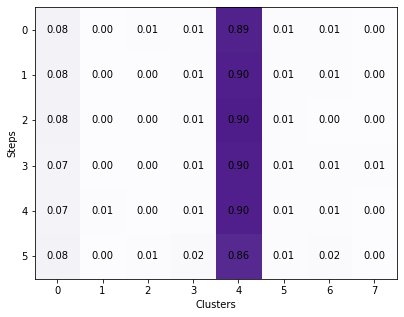

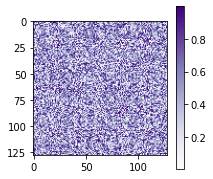

In [22]:
uniques = np.unique(clusters)
unique_names = np.unique(timesteps_per_condition)
proportions = np.zeros((len(unique_names), len(uniques)))
timesteps = np.array(timesteps_per_condition)
for i, unique in enumerate(uniques):
    mask = clusters == unique 
    
    timestep, counts = np.unique(timesteps[mask], return_counts=True)
    for t, c in zip(timestep, counts):
        proportions[t, i] = c 

proportions = proportions / np.sum(proportions, axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(proportions, vmin=0, vmax=1.0, cmap="Purples")
for j in range(proportions.shape[1]):
    for i in range(proportions.shape[0]):
        ax.text(j, i, f'{proportions[i, j]:.2f}', ha='center', va='center', color='black')

ax.set(
    xlabel="Clusters", ylabel="Steps"
)
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
im = ax.imshow(np.random.rand(128, 128), cmap="Purples")
cbar = fig.colorbar(im, ax=ax)
plt.show()

# fig, ax = plt.subplots(figsize=())

### Mapping back to manual features

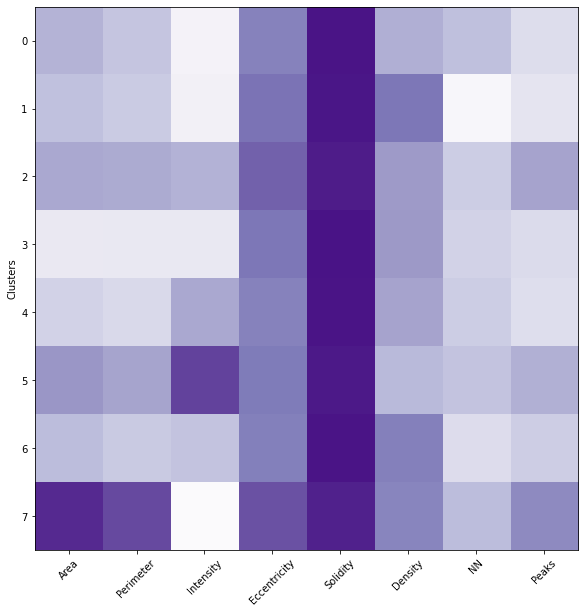

In [23]:
from sklearn.linear_model import Ridge

class MaskedMinMaxScaler:
    def __init__(self):

        self.mean = None 
        self.std = None

        self.min = None
        self.max = None

    def fit_transform(self, X, mask):
        self.fit(X, mask)
        return self.transform(X)
    
    def fit(self, X, mask):
        # self.mean = numpy.mean(X, axis=0, keepdims=True)
        # self.std = numpy.std(X, axis=0, keepdims=True)
        self.min = np.min(X, axis=0, keepdims=True)
        self.max = np.max(X, axis=0, keepdims=True)

        mask = np.array(mask)
        # self.mean[:, ~mask] = 0
        # self.std[:, ~mask] = 1

        self.min[:, ~mask] = 0
        self.max[:, ~mask] = 1

    def transform(self, X):
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet")
        X = (X - self.min) / (self.max - self.min)
        return X

trajectories = np.concatenate(trajectories_per_condition, axis=0)
uniques = np.unique(clusters)
assert trajectories.shape[0] == clusters.shape[0]
scaler = MaskedMinMaxScaler()
trajectories = scaler.fit_transform(trajectories, [f not in ["Eccentricity", "Solidity"] for f in FEATURES])

correlation_matrix = np.zeros((len(uniques), trajectories.shape[-1]))
for i, cluster_id in enumerate(uniques):
    mask = clusters == cluster_id 
    traj = trajectories[mask]

    for feature_idx in range(traj.shape[-1]):
        correlation_matrix[i, feature_idx] = np.mean(traj[:, feature_idx])


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(correlation_matrix, cmap="Purples", vmin=0, vmax=1)
ax.set(
    ylabel="Clusters",
)
ax.set_xticks(
    np.arange(0, trajectories.shape[-1], 1), labels=[FEATURES[i] for i in range(trajectories.shape[-1])],
    rotation=45
)
plt.show()